[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/02.regression/c.regularization.ipynb)

# REDO THIS WITH THE USUAL DATASET, TO GIVE THIS DATASET TO STUDENTS

We will use the [Poqemon-QoE-Dataset](https://github.com/Lamyne/Poqemon-QoE-Dataset) used in:

Lamine Amour, Sami Souihi, Abdelhamid Mellouk: ACR-based Subjective QoE Datasets to Quantify YouTube Video Quality. QoMEX, 2018 (Submitted).

The goal is to predict the Mean Opinion Score (MOS) from information about transmission and video received by the client.

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from math import sqrt
from statistics import mean
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

!pip install regressors
from regressors import stats # To print information about 
                            # regression. 


## Download the code I prepared for you
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

from andrea_models import AndreaLinearRegression # In the course library
from visualization import rotate_labels

--2020-03-03 14:29:07--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150 (2.1K) [text/plain]
Saving to: ‘andrea_models.py.6’

andrea_models.py.6  100%[===================>]   2.10K  --.-KB/s    in 0s      

2020-03-03 14:29:08 (45.0 MB/s) - ‘andrea_models.py.6’ saved [2150/2150]

--2020-03-03 14:29:09--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reque

In [0]:
savefigures = False

In [3]:
!wget https://raw.githubusercontent.com/Lamyne/Poqemon-QoE-Dataset/master/VLC-QoS-QoEIF-.csv

file='VLC-QoS-QoEIF-.csv'
df = pd.read_csv(file, sep=";")
df.info(verbose=True)

--2020-03-03 14:29:12--  https://raw.githubusercontent.com/Lamyne/Poqemon-QoE-Dataset/master/VLC-QoS-QoEIF-.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59082 (58K) [text/plain]
Saving to: ‘VLC-QoS-QoEIF-.csv.5’

VLC-QoS-QoEIF-.csv. 100%[===================>]  57.70K  --.-KB/s    in 0.03s   

2020-03-03 14:29:12 (2.12 MB/s) - ‘VLC-QoS-QoEIF-.csv.5’ saved [59082/59082]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 30 columns):
id                       300 non-null int64
QoS_bandwidth            300 non-null int64
QoS_packet-loss          300 non-null object
QoS_delay                300 non-null float64
QoS_jitter               300 non-null float64
V_id-video               300 non-null int64
V_content           

In [4]:
df.head()

,id,QoS_bandwidth,QoS_packet-loss,QoS_delay,QoS_jitter,V_id-video,V_content,V_norm-bitrate,V_complexity,V_complexity-class,QoA_resolution,QoA-bitrate,QoA-frame_rate,QoA_frame-drop,QoA_audio-rate,QoA_audio-drop,QoD-cpu_mhz-moy,QoD-cpu_mhz-avg,QoD_cpu-nbr,QoD-cpu_core-nbr,QoD_stepping,QoD-cpu_bigo-mips,QoD_carte-class,QoD_screen-resolotion,QoD_screen-dimension,QoD_screen-mhz,QoD-screen_blug-type,QoD-ram_clock-speed,QoD_ram-size,MOS
0,1,1024,0%,0.360,0.043,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1278.000000,697.650502,4,2,7,4988.58,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1
1,2,1024,0%,0.435,0.071,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,2600.555556,894.924095,8,4,9,6784.45,Radeon HD 7470,1920 x 1200,508x317,154.0,DVI-0,1600,4096,1
2,16,1024,0%,0.403,0.033,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1544.777778,833.197159,4,2,7,4988.58,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1
3,18,1024,0%,0.499,0.018,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1177.888889,586.723566,4,2,7,4988.76,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1
4,19,1024,0%,0.472,0.034,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1533.555556,820.830759,4,2,7,4988.76,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1


Let's check if we really need `QoS_packet-loss`

In [5]:
# Returns the unique values
set( df['QoS_packet-loss'])

{'0%'}

We do not need it.

In [6]:
df = df.drop('QoS_packet-loss', axis=1)
df.head()

,id,QoS_bandwidth,QoS_delay,QoS_jitter,V_id-video,V_content,V_norm-bitrate,V_complexity,V_complexity-class,QoA_resolution,QoA-bitrate,QoA-frame_rate,QoA_frame-drop,QoA_audio-rate,QoA_audio-drop,QoD-cpu_mhz-moy,QoD-cpu_mhz-avg,QoD_cpu-nbr,QoD-cpu_core-nbr,QoD_stepping,QoD-cpu_bigo-mips,QoD_carte-class,QoD_screen-resolotion,QoD_screen-dimension,QoD_screen-mhz,QoD-screen_blug-type,QoD-ram_clock-speed,QoD_ram-size,MOS
0,1,1024,0.360,0.043,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1278.000000,697.650502,4,2,7,4988.58,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1
1,2,1024,0.435,0.071,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,2600.555556,894.924095,8,4,9,6784.45,Radeon HD 7470,1920 x 1200,508x317,154.0,DVI-0,1600,4096,1
2,16,1024,0.403,0.033,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1544.777778,833.197159,4,2,7,4988.58,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1
3,18,1024,0.499,0.018,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1177.888889,586.723566,4,2,7,4988.76,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1
4,19,1024,0.472,0.034,3,Movie,6.422284,5.874106,0,144,79.0,10.666667,0.0,23.0,0.0,1533.555556,820.830759,4,2,7,4988.76,Radeon HD 7610M,1366 x 768,361x203,76.5,LVDS,1333,4096,1


Let's try to infer MOS from the following features

In [0]:
features = ['QoS_delay', 'QoS_jitter', 
            'QoA_resolution', 'V_norm-bitrate', 
           'QoA-bitrate', 'QoA-frame_rate', 'QoA_frame-drop',
           'QoA_audio-rate', 'QoA_audio-drop', 
            'QoD-cpu_mhz-avg', 'QoD_cpu-nbr']



X = df[features].values
y = df['MOS'].values

We will try different parameters of a model on the training set and evaluate their performance on the test set.

In [0]:
X_train, X_test, y_train, y_test =train_test_split(
    X,y, test_size=0.2, shuffle=True, random_state=7)

Let's first try a simple linear regression

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_lin = sqrt(mean_squared_error(y_pred, y_test) )
RMSE_lin

0.65021592316979

First, see that `Ridge` with `alpha=0`, the model becomes a simple linear regression.

In [10]:
# The implementation of Ridge regression does not behave well with
# alpha=0, as it expects alpha > 0
model = Ridge(alpha=1e-9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )

0.6502159231357222

Let's try with some `alpha > 0`

In [11]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )


0.6500183244027237

Find the best alpha in the training set and report the cross validation error. 

**When looking for the best parameter, use training data only** (otherwise you have **data leakage**).

(We do not use pipelines because we want to plot errors)

,alphas,errors
0,1e-09,0.589968
1,0.5,0.585732
2,1,0.584879
3,10,0.580221
4,100,0.566458
5,1000,0.559074
6,10000,0.569970
7,100000.0,0.722401
8,1000000.0,0.829704


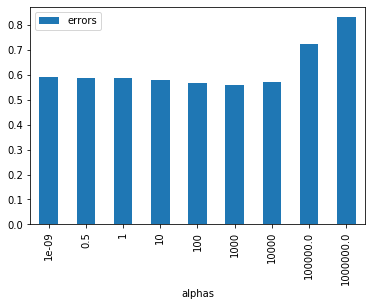

In [12]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=10)

alphas = [1e-9, 0.5, 1, 10, 100, 1000, 10000, 1e5, 1e6]
errors = []
for a in alphas:
    scores = cross_val_score(Ridge(alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
# We convert x-values to string because otherwise they would 
# be to far from each other
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

Let's analyze the best Ridge regression model.

In [13]:
model = Ridge(alpha=1000)
model.fit(X_train, y_train)
stats.summary(model, X_train, y_train)

Residuals:
    Min      1Q  Median      3Q     Max
 0.7576  2.2976  3.0047  4.1367  5.5629


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept -0.020460    0.275418  -0.0743  0.940844
x1         -0.000476    0.513804  -0.0009  0.999262
x2         -0.000019    2.287024  -0.0000  0.999993
x3          0.002188    0.000208  10.5303  0.000000
x4          0.017577    0.015366   1.1439  0.253813
x5          0.000163    0.000054   3.0110  0.002883
x6          0.016614    0.006172   2.6920  0.007605
x7         -0.016762    0.034268  -0.4892  0.625175
x8          0.042056    0.003265  12.8814  0.000000
x9         -0.002159    0.011962  -0.1805  0.856952
x10         0.000033    0.000073   0.4470  0.655307
x11        -0.007668    0.016611  -0.4616  0.644779
---
R-squared:  0.83466,    Adjusted R-squared:  0.82669
F-statistic: 104.64 on 11 features


In [14]:
print("The significant coefficients are for ", features[3-1],
      features[5-1], features[6-1], features[8-1] )

The significant coefficients are for  QoA_resolution QoA-bitrate QoA-frame_rate QoA_audio-rate


Regularization does not seem to improve w.r.t. the linear model.

May there be some non-linear dependency?

# Polynomial regression and regularization

Let's try a polynomial regression

In [15]:
def MyPolynomialRegression(degree=2, include_bias=False):
    return make_pipeline(PolynomialFeatures(degree, include_bias),
                LinearRegression() )


model = MyPolynomialRegression(degree=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_quadr = sqrt(mean_squared_error(y_pred, y_test) )
print("RMSE quadr: ", RMSE_quadr, "RMSE linear: ", RMSE_lin)

RMSE quadr:  3.552732150127509 RMSE linear:  0.65021592316979


Clearly, **overfitting**.

Let's modify `MyPolynomialRegression` in order to make ridge regression instead of simple linear regression in the last step.

In [0]:
def MyPolynomialRegression(degree=2, include_bias=False, 
                           alpha=1e-9):
    return make_pipeline(PolynomialFeatures(degree, 
                                            include_bias),
                Ridge(alpha=alpha) )

,alphas,errors
0,0.5,3.403001
1,1,3.052019
2,10,2.324020
3,100,1.694671
4,1000,1.246561
5,100000.0,0.611480
6,1000000.0,0.626008
7,10000000.0,0.627981
8,1000000000.0,0.560663
9,1000000000000.0,0.946681


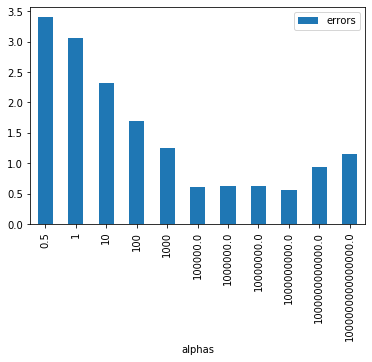

In [17]:
alphas = [0.5, 1, 10, 100, 1000, 1e5, 1e6, 1e7, 1e9, 1e12, 1e15]
errors = []
for a in alphas:
    scores = cross_val_score(MyPolynomialRegression(degree=2,
                    include_bias=False, alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

Let's compute the test error for the best alpha

In [18]:
model = MyPolynomialRegression(degree=2, alpha=1e9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_poly_and_ridge = sqrt(mean_squared_error(y_pred, y_test) )
print("RMSE_poly_and_ridge: ", RMSE_poly_and_ridge,
      "RMSE linear: ", RMSE_lin)

RMSE_poly_and_ridge:  0.5923726157888944 RMSE linear:  0.65021592316979


A simple average is better than the linear model!

# Feature scaling

Go back to slides

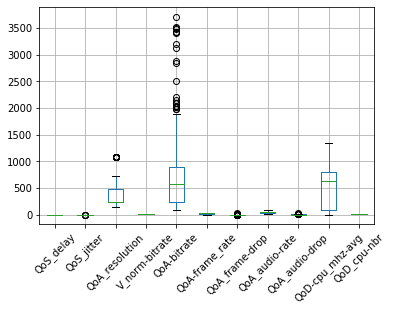

In [19]:
ax = df[features].boxplot()
ax.tick_params(axis='x', labelrotation=45)


In [0]:
if savefigures:
  from google.colab import drive
  mount_point = '/content/gdrive'
  drive.mount(mount_point, force_remount=True)
  drive_path = mount_point+'/My Drive/'
  my_path = drive_path + 'tsp/teaching/data-science-for-networks/img-from-code/02.regression/'

  plt.savefig(my_path+'c.boxplot.pdf')

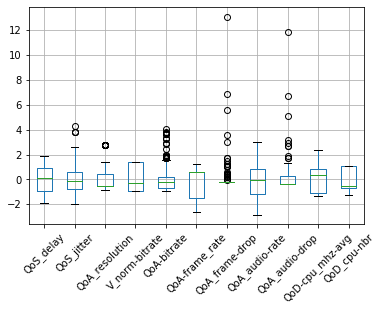

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled)
df_scaled.columns = features
ax = df_scaled.boxplot()
ax.tick_params(axis='x', labelrotation=45)

if savefigures:
  plt.savefig(my_path+'c.boxplot-scaled.pdf')

Scaling is usually included in the pipelines. Pipelines will use it correctly (train/test).

Let's construct a pipeline with scaling and Ridge regression.

In [0]:
def MyScalingAndPolyRidge(degree=2, alpha=2):
    return make_pipeline(
       PolynomialFeatures(degree=degree, include_bias=False),
        MinMaxScaler(),
        Ridge(alpha=alpha)
    )

Let's find the best alpha with GridSearch

,alphas,errors
0,1e-09,6.043232
1,0.1,0.561536
2,0.2,0.554337
3,0.5,0.557097
4,1,0.560844
5,10,0.573534
6,100,0.742585
7,1000,1.156721
8,100000.0,1.301020
9,1000000.0,1.302610


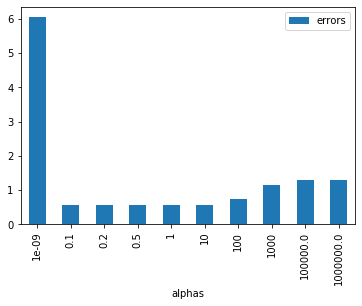

In [23]:
alphas = [1e-9, 0.1, 0.2, 0.5, 1, 10, 100, 1000, 1e5, 1e6]
errors = []
for a in alphas:
    scores = cross_val_score(MyScalingAndPolyRidge(degree=2,
                    alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

After scaling, the best $\alpha$ is 0.2.

In [24]:
model = MyScalingAndPolyRidge(degree=2,
                    alpha=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_scaling_and_poly_and_ridge = \
    sqrt(mean_squared_error(y_pred, y_test) )
    
print("RMSE_scaling_and_poly_and_ridge: ",
      RMSE_scaling_and_poly_and_ridge,
      ", RMSE_poly_and_ridge:", 
      RMSE_poly_and_ridge)

RMSE_scaling_and_poly_and_ridge:  0.5201105216337418 , RMSE_poly_and_ridge: 0.5923726157888944


# Grid search

Let's find the best combination of polynomial degree and regularization weight.

Let's check how parameters are called

In [25]:
GridSearchCV(MyScalingAndPolyRidge(), []).get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__polynomialfeatures', 'estimator__minmaxscaler', 'estimator__ridge', 'estimator__polynomialfeatures__degree', 'estimator__polynomialfeatures__include_bias', 'estimator__polynomialfeatures__interaction_only', 'estimator__polynomialfeatures__order', 'estimator__minmaxscaler__copy', 'estimator__minmaxscaler__feature_range', 'estimator__ridge__alpha', 'estimator__ridge__copy_X', 'estimator__ridge__fit_intercept', 'estimator__ridge__max_iter', 'estimator__ridge__normalize', 'estimator__ridge__random_state', 'estimator__ridge__solver', 'estimator__ridge__tol', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [0]:
parameters_to_test=[{'ridge__alpha':[0.1, 0.2, 0.5, 1, 5, 10, 50, 
                             1e6],
                     'polynomialfeatures__degree':np.arange(1,6)
                    }]
grid = GridSearchCV(MyScalingAndPolyRidge(), parameters_to_test,
                    cv=k_fold, scoring='neg_mean_squared_error'
    )

In [27]:
grid.fit(X_train, y_train)
print("The best parameters are", grid.best_params_)

The best parameters are {'polynomialfeatures__degree': 2, 'ridge__alpha': 0.2}


Let's validate on the test set

In [28]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_grid = sqrt(mean_squared_error(y_pred, y_test))
print("RMSE_grid:", RMSE_grid, ", quadr.model + ridge RMSE:",
     RMSE_scaling_and_poly_and_ridge)

RMSE_grid: 0.5201105216337418 , quadr.model + ridge RMSE: 0.5201105216337418


# Recursive Feature Elimination

In [0]:
def MyScaledLinearRegression():
    return make_pipeline(
        StandardScaler(),
        LinearRegression()
        )

The following code will lead to a **known error**

In [30]:
# The following code will lead to a known error

rfe = RFECV(MyScaledLinearRegression())
rfe.fit(X_train, y_train)

RuntimeError: ignored

We need to modify the `Pipeline` class (inspired by [this blog](https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/) and this [StackOverflow post](https://stackoverflow.com/q/36683230/2110769))

In [0]:
class MyPipeline(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(MyPipeline, self).fit(X, y, **fit_params)
        self.coef_ = self.steps[-1][-1].coef_
        return self

Let's try again

In [32]:
def MyScaledLinearRegression():
    return MyPipeline(
        [ 
            ('my_nice_scaler',StandardScaler() ), 
            ('my_beautiful_regression', LinearRegression() )
        ]
    )

rfe = RFECV(MyScaledLinearRegression(), cv=k_fold, 
            scoring='neg_mean_squared_error')
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
      estimator=MyPipeline(memory=None,
                           steps=[('my_nice_scaler',
                                   StandardScaler(copy=True, with_mean=True,
                                                  with_std=True)),
                                  ('my_beautiful_regression',
                                   LinearRegression(copy_X=True,
                                                    fit_intercept=True,
                                                    n_jobs=None,
                                                    normalize=False))],
                           verbose=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

Let's check how the cross-validated error changed with the num of features

In [33]:
RMSE_values = np.sqrt(- rfe.grid_scores_)
RMSE_values

array([0.87379709, 0.55692171, 0.57596145, 0.57695686, 0.56897865,
       0.58660279, 0.5851578 , 0.58562005, 0.5868528 , 0.58999872,
       0.58996762])

[Text(0, 0.5, 'Cross-Val RMSE'), Text(0.5, 0, 'Num of features')]

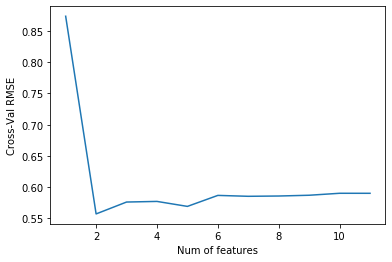

In [34]:
num_of_features = np.arange(1,len(features)+1)

fig, ax = plt.subplots()
ax.plot(num_of_features, RMSE_values)
ax.set(xlabel="Num of features", ylabel="Cross-Val RMSE")

Two features seem to give the best model. What are such features?

In [35]:
all_features_array = np.array(features)
selected_features = all_features_array[rfe.support_]
selected_features

array(['QoA_resolution', 'QoA_audio-rate'], dtype='<U15')

Let's test the selected model

In [36]:
y_pred = rfe.predict(X_test)
RMSE_feat_elimin = sqrt(mean_squared_error(y_pred, y_test))
print('RMSE_feat_elimin=', RMSE_feat_elimin, ', RMSE_grid', RMSE_grid,
     ', RMSE_lin', RMSE_lin)

RMSE_feat_elimin= 0.5491052022377344 , RMSE_grid 0.5201105216337418 , RMSE_lin 0.65021592316979


This model is better than the linear regression where we had all the features. However, the one we found with grid (best polynomial with ridge regularization) is still the best.

Some idea to improve even more the model?

<details>
<summary>...
    
__Click__
</summary>

* Find the best polynomial + normalization model based only on these two features. Or
* Use RFECV on the polynomial model to select a subset of transformed features. Or
* 
</details>